# **CASCADE 2**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import scipy.stats
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, auc
from sklearn.pipeline import Pipeline
from scipy.stats import sem
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.inspection import permutation_importance
import shap
import warnings
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, silhouette_score, calinski_harabasz_score
from itertools import combinations_with_replacement
from copy import deepcopy
from sklearn.neural_network import MLPClassifier, MLPRegressor
from kneed import KneeLocator
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from kmodes.kmodes import KModes
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.metrics import pairwise_distances
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import RFECV
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from math import sqrt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [10]:
def compute_grid_search_regression(model, param_grid, X_train, y_train):
    """
    Perform a grid search on a model using K-Fold cross-validation for regression.
    
    Parameters:
    - model: Estimator or model to be used.
    - param_grid: Dictionary of parameters for grid search.
    - X_train: Training data features.
    - y_train: Training data targets.
    
    Returns:
    - grid_search: Fitted GridSearchCV object.
    """

    # Create KFold instance
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Set up the grid search with 'neg_mean_squared_error' as the scoring metric
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=kf, 
        scoring='neg_mean_squared_error',  # Using negative mean squared error for regression
        verbose=1,  
        n_jobs=-1   
    )
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    
    return grid_search


In [11]:
def regressor_model_pipeline(X_train, y_train, X_test, y_test, model, metrics_list, params={}, 
                   k=10, SHAP=False, importances=False, standardize=False, columns_to_standardize=None):
    """
    Creates a regression model pipeline, computes cross-validation and test metrics, and optionally 
    provides feature importance and SHAP value analysis.

    Args:
        X_train (pd.DataFrame): Training data features.
        y_train (pd.Series or array-like): Training data labels.
        X_test (pd.DataFrame): Test data features.
        y_test (pd.Series or array-like): Test data labels.
        model (estimator class): Estimator class (uninitialized) to be used.
        metrics_list (list of str): List of metrics ('mae', 'mse', 'rmse') to compute.
        params (dict, optional): Dictionary of parameters to initialize the model with. Defaults to {}.
        k (int, optional): Number of folds in KFold cross-validation. Defaults to 10.
        SHAP (bool, optional): Whether to compute and display SHAP values. Defaults to False.
        importances (bool, optional): Whether to compute feature importances. Defaults to False.
        standardize (bool, optional): Whether to standardize certain columns in the data. Defaults to False.
        columns_to_standardize (list of str, optional): Columns in the data to standardize. Only used if `standardize` is True. Defaults to None.

    Returns:
        dict: Dictionary containing a DataFrame with the cross-validation results ('cv_results'), a  DataFrame with test results ('test_results'),
        the predicted values for the test set ('y_test_pred'), and a DataFrame containing the feature importance analysis ('feature_importances') 
        if `importances` is True.
    """
     
    # Map metric names to functions
    metrics = {
        'mae': mean_absolute_error,
        'mse': mean_squared_error,
        'rmse': lambda y_true, y_pred: sqrt(mean_squared_error(y_true, y_pred))
    }

    # Check if we necessary to standardize a subset of columns
    if standardize and columns_to_standardize:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), columns_to_standardize)
            ],
            remainder='passthrough'  # leave remaining columns untouched
        )
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model(**params))
        ])
    else:
        pipeline = Pipeline([
            ('model', model(**params))
        ])

    # Initialize KFold cross-validation
    cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Compute the specified metrics using cross-validation
    cv_results = {}
    for metric in metrics_list:
        scorer = make_scorer(metrics[metric])

        #def custom_scorer(pipe, X, y, scorer=scorer):
        #    y_pred = pipe.predict(X)
        #    return scorer._score_func(y, np.maximum(np.round(y_pred), 0))
        
        def custom_scorer(pipe, X, y, scorer=scorer):
            y_pred = pipe.predict(X)
            if not np.all(np.isfinite(y_pred)):
                print('There is a problem and infinite values are present')
                return np.inf  # Return large error if predictions are not finite
            return scorer._score_func(y, np.maximum(np.round(y_pred), 0))


        cv_scores = cross_val_score(pipeline, X_train, y_train, scoring=custom_scorer, cv=cv)
        cv_results[metric] = (np.mean(cv_scores), np.std(cv_scores))

    cv_results = pd.DataFrame(cv_results, columns=metrics_list).T
    cv_results.columns = ['Mean', 'Standard Deviation']
    cv_results = cv_results.T

    # Fit the model on the full training set
    pipeline.fit(X_train, y_train)

    # Feature importances
    if importances:
        feature_importances = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            fitted_model = pipeline.named_steps['model']

            if hasattr(fitted_model, 'feature_importances_'):
                fold_importance = fitted_model.feature_importances_
            elif hasattr(fitted_model, 'coef_'):
                fold_importance = np.abs(fitted_model.coef_[0])
            else:
                perm_importance = permutation_importance(fitted_model, X_test_fold, y_test_fold)
                fold_importance = perm_importance.importances_mean

            feature_importances.append(fold_importance)

        # Compute mean and standard deviation of feature importances
        feature_importances_mean = np.mean(feature_importances, axis=0)
        feature_importances_std = np.std(feature_importances, axis=0)
        
        importances_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance_mean': feature_importances_mean,
            'importance_std': feature_importances_std
            })
        
        # Sort by importance_mean in descending order
        importances_df = importances_df.sort_values(by='importance_mean', ascending=False)
    
    else:
        importances_df = pd.DataFrame()

    # Compute the specified metrics on the test set
    test_results = {}
    y_test_pred = pipeline.predict(X_test)
    y_test_pred_rounded = np.maximum(np.round(y_test_pred), 0)
    for metric in metrics_list:
        scorer = metrics[metric]
        test_score = scorer(y_test, y_test_pred_rounded)
        test_results[metric] = test_score

    test_results = pd.DataFrame(test_results, index=['Value'], columns=metrics_list).T
    test_results = test_results.T

    # Output mean and std of cross-validation scores and test set scores
    output = {
        'cv_results': cv_results,
        'test_results': test_results,
        'y_test_pred': y_test_pred_rounded,
    }

    output['feature_importances'] = importances_df

    # Print CV results
    print('')
    print('CV RESULTS')
    display(cv_results)
    print('')

    #Print Test results
    print('TEST RESULTS')
    display(test_results)
    print('')

    #Print Features analysis
    if importances:
        print('FEATURES ANALYSIS')
        display(importances_df.head(20))

    if SHAP:
        # Compute SHAP values
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            explainer = shap.TreeExplainer(pipeline.named_steps['model'])
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

        elif hasattr(pipeline.named_steps['model'], 'coef_'):
            explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_train)
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

    return output

In [12]:
class ZINBWrapper(BaseEstimator, RegressorMixin):
    """
    A wrapper for the Zero-Inflated Negative Binomial (ZINB) model from the statsmodels library.
    
    This wrapper allows easy integration with scikit-learn pipelines and utilities, and
    adds functionality for controlling the exogenous variables used for inflation modeling.
    
    Attributes:
        params (dict): Parameters for controlling the behavior of the model. Accepted keys include:
            - 'use_all_covariates_for_inflation' (bool): If True, uses all covariates for the inflation model. Defaults to False.
            - 'maxiter' (int): Maximum number of iterations for model fitting. Default behavior is determined by the underlying statsmodels method.
    """

    def __init__(self, **params):
        self.params = params
        
    def fit(self, X, y):
        """
        Fits the ZINB model on provided data.
        
        Args:
            X (pd.DataFrame or array-like): Exogenous variables.
            y (pd.Series or array-like): Endogenous variable (target).
            
        Returns:
            self: Returns an instance of the model.
        """
        # Check if the 'use_all_covariates_for_inflation' parameter is True
        if self.params.get('use_all_covariates_for_inflation', False):
            self.model_ = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=X, exog_infl=X)
        else:
            self.model_ = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=X)

        self.result_ = self.model_.fit(maxiter=self.params.get('maxiter'))
        return self

    def predict(self, X):
        """
        Makes predictions using the fitted ZINB model.
        
        Args:
            X (pd.DataFrame or array-like): Exogenous variables for prediction.
            
        Returns:
            array-like: Predicted values.
            
        Raises:
            RuntimeError: If the model has not been trained before making predictions.
        """
        if not hasattr(self, 'result_'):
            raise RuntimeError("You must train the model before making predictions!")
        
        # Decide the exog_infl based on parameters
        exog_infl = X if self.params.get('use_all_covariates_for_inflation', False) else None
        
        return self.result_.predict(exog=X, exog_infl=exog_infl)

## **Data**

In [13]:
TRAIN = pd.read_parquet('TRAIN_2016.parquet')
TEST = pd.read_parquet('TEST_2016.parquet')

In [14]:
TRAIN.columns

Index(['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI',
       'CAUSE__OF_INFERTILITY__TUBAL_DISEASE',
       'CAUSE_OF_INFERTILITY__OVULATORY_DISORDER',
       'CAUSE_OF_INFERTILITY__MALE_FACTOR',
       'CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED',
       'CAUSE_OF_INFERTILITY__ENDOMETRIOSIS', 'STIMULATION_USED', 'SPERM_FROM',
       'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED',
       'LIVE_BIRTH_OCCURRENCE', 'SCREENING', 'SPECIFIC_TREATMENT_TYPE_IVF',
       'PREVIOUS_LIVE_BIRTH_IVF_OR_DI'],
      dtype='object')

In [15]:
# Oocytes Retrieved
X_train_eggs = TRAIN.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE', 'SPECIFIC_TREATMENT_TYPE_IVF'], axis=1)
y_train_eggs = TRAIN['FRESH_EGGS_COLLECTED']
X_test_eggs = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE', 'SPECIFIC_TREATMENT_TYPE_IVF'], axis=1)
y_test_eggs = TEST['FRESH_EGGS_COLLECTED']

# Embryos Created
X_train_embryos = TRAIN.drop(['TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
y_train_embryos = TRAIN['TOTAL_EMBRYOS_CREATED']
# X_test will be made later to include predictions
y_test_embryos = TEST['TOTAL_EMBRYOS_CREATED']

# Live Birth
X_train_live_birth = TRAIN.drop(['LIVE_BIRTH_OCCURRENCE'], axis=1)
y_train_live_birth = TRAIN['LIVE_BIRTH_OCCURRENCE']
# X_test will be made later to include predictions
y_test_live_birth = TEST['LIVE_BIRTH_OCCURRENCE']

## **STAGE 1 MODELS**

### Zero-inflated Negative binomial (ZINB)

In [71]:
model = ZINBWrapper
metrics_list = ['mae', 'mse', 'rmse']
params = {'use_all_covariates_for_inflation': True, 'maxiter': 1000}
results_ZINB = regressor_model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10)

Optimization terminated successfully.
         Current function value: 3.041499
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 3.041566
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 3.041138
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 3.039230
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 3.039676
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 3.039500
         Iterations: 32
         Function evaluations: 35
  

Inverting hessian failed, no bse or cov_params available


,mae,mse,rmse
Mean,4.437684,33.120362,5.754172
Standard Deviation,0.067556,1.143151,0.099314



TEST RESULTS


,mae,mse,rmse
Value,4.452673,33.438505,5.782604


### Random Forest Regressor (RFR)

In [29]:
model = RandomForestRegressor
metrics_list = ['mae', 'mse', 'rmse']
params = {'random_state': 42}
results_RFR = regressor_model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,4.475994,33.902838,5.821982
Standard Deviation,0.054819,1.002251,0.085810



TEST RESULTS


,mae,mse,rmse
Value,4.469461,34.073937,5.837289


### XGBoost Regressor (XGBR)

In [30]:
model = XGBRegressor
metrics_list = ['mae', 'mse', 'rmse']
params = {'random_state': 42, 'objective':'reg:squarederror'}
results_XGBR = regressor_model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,4.456943,33.619267,5.797464
Standard Deviation,0.061322,1.082189,0.093132



TEST RESULTS


,mae,mse,rmse
Value,4.452078,33.7589,5.810241


### Support Vector Regressor (SVR)

In [35]:
model = SVR
metrics_list = ['mae', 'mse', 'rmse']
params = {}
results_SVR = regressor_model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,4.380949,33.523024,5.789089
Standard Deviation,0.065306,1.126322,0.097303



TEST RESULTS


,mae,mse,rmse
Value,4.383379,33.811644,5.814778


In [42]:
param_grid = params = { 'C':[0.001, 0.01, 0.1, 1.0, 10], 'epsilon':[0.001, 0.01, 0.1, 1]}
compute_grid_search_regression(SVR(), param_grid, X_train_eggs, y_train_eggs)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'C': 1.0, 'epsilon': 1}


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
model = SVR
metrics_list = ['mae', 'mse', 'rmse']
params = {'C':1, 'epsilon':1}
results_BEST1 = regressor_model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,4.380562,33.48871,5.786081
Standard Deviation,0.065451,1.15643,0.099869



TEST RESULTS


,mae,mse,rmse
Value,4.388261,33.877247,5.820416


### Multilayer Perceptron Regressor (MLPR)

In [34]:
model = MLPRegressor
metrics_list = ['mae', 'mse', 'rmse']
params = {'random_state': 42, 'max_iter':1000}
results_MLPR = regressor_model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,4.418931,33.028264,5.746250
Standard Deviation,0.067358,1.084488,0.094198



TEST RESULTS


,mae,mse,rmse
Value,4.429337,33.19538,5.761543


## **STAGE 2 MODELS**

In [17]:
X_test_embryos = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_test_embryos['FRESH_EGGS_COLLECTED'] = results_BEST1['y_test_pred'].astype(int)
X_test_embryos = X_test_embryos.reindex(columns=X_train_embryos.columns)

In [18]:
print(y_train_embryos.mean())
print(y_train_embryos.median())
print(y_train_embryos.mode())

5.100104182169966
4.0
0    0
Name: TOTAL_EMBRYOS_CREATED, dtype: int64


In [132]:
binary_features = ['CAUSE__OF_INFERTILITY__TUBAL_DISEASE',
       'CAUSE_OF_INFERTILITY__OVULATORY_DISORDER',
       'CAUSE_OF_INFERTILITY__MALE_FACTOR',
       'CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED',
       'CAUSE_OF_INFERTILITY__ENDOMETRIOSIS', 'STIMULATION_USED', 'SPERM_FROM',
       'SCREENING', 'SPECIFIC_TREATMENT_TYPE_IVF',
       'PREVIOUS_LIVE_BIRTH_IVF_OR_DI']

ordinal_features = ['PATIENT_AGE_AT_TREATMENT']

count_features = ['TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI']

# Temporary list to store the dictionaries
temp_list = []

# For binary predictors (Count X Binary)
for feature in binary_features:
    corr, p_value = scipy.stats.pointbiserialr(X_train_embryos['FRESH_EGGS_COLLECTED'], X_train_embryos[feature])
    temp_list.append({'Coefficient Type': 'Rank-Biserial',
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# For ordinal predictors (Count X Ordinal)
for feature in ordinal_features:
    corr, p_value = scipy.stats.spearmanr(X_train_embryos['FRESH_EGGS_COLLECTED'], X_train_embryos[feature])
    temp_list.append({'Coefficient Type': 'Spearman', 
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# For count predictors (Count X Count)
for feature in count_features:
    corr, p_value = scipy.stats.spearmanr(X_train_embryos['FRESH_EGGS_COLLECTED'], X_train_embryos[feature])
    temp_list.append({'Coefficient Type': 'Spearman', 
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# Create DataFrame from list of dictionaries
embryos_created_corr_df = pd.DataFrame(temp_list)

# Sort and display the DataFrame
embryos_created_corr_df['abs_coefficient'] = embryos_created_corr_df['Coefficient Value'].abs()
embryos_created_corr_df.sort_values(by='abs_coefficient', ascending=False, inplace=True)
embryos_created_corr_df.drop(columns='abs_coefficient', inplace=True)
#cm = sns.diverging_palette(200, 37, as_cmap=True)
#display(embryos_created_corr_df.style.background_gradient(cmap = cm, axis=0, subset='Coefficient Value'))

display(embryos_created_corr_df)

,Coefficient Type,Variable,Coefficient Value,P Value
10,Spearman,PATIENT_AGE_AT_TREATMENT,-0.278,0.000
5,Rank-Biserial,STIMULATION_USED,0.166,0.000
8,Rank-Biserial,SPECIFIC_TREATMENT_TYPE_IVF,-0.136,0.000
1,Rank-Biserial,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,0.095,0.000
11,Spearman,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,-0.056,0.000
2,Rank-Biserial,CAUSE_OF_INFERTILITY__MALE_FACTOR,0.052,0.000
4,Rank-Biserial,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,-0.033,0.000
7,Rank-Biserial,SCREENING,0.029,0.000
3,Rank-Biserial,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.012,0.031
0,Rank-Biserial,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,0.007,0.232


### Zero-inflated Negative binomial (ZINB)

In [109]:
# class ZINBWrapper(BaseEstimator, RegressorMixin):
#     def __init__(self, use_all_covariates_for_inflation=False, maxiter=100, method='bfgs'):
#         self.use_all_covariates_for_inflation = use_all_covariates_for_inflation
#         self.maxiter = maxiter
#         self.method = method
        
#     def fit(self, X, y):
#         exog_infl = X if self.use_all_covariates_for_inflation else None
#         self.model_ = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=X, exog_infl=exog_infl)
#         self.result_ = self.model_.fit(maxiter=self.maxiter, method=self.method)
#         return self

#     def predict(self, X):
#         if not hasattr(self, 'result_'):
#             raise RuntimeError("You must train the model before making predictions!")
        
#         return self.result_.predict(exog=X)


In [117]:
# ZINB WITHOUT FRESH_EGGS_COLLECTED
model = ZINBWrapper
metrics_list = ['mae', 'mse', 'rmse']
params = {'use_all_covariates_for_inflation': True, 'maxiter': 3000}
results_ZINB = regressor_model_pipeline(X_train_embryos.drop(columns=['FRESH_EGGS_COLLECTED'], axis=1), 
                                        y_train_embryos, X_test_embryos.drop(columns=['FRESH_EGGS_COLLECTED'], axis=1), 
                                        y_test_embryos, model, metrics_list, params, 
k=10, standardize=False, columns_to_standardize=['FRESH_EGGS_COLLECTED'])

Optimization terminated successfully.
         Current function value: 2.623264
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 2.624021
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 2.624764
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 2.623068
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 2.622606
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 2.625456
         Iterations: 38
         Function evaluations: 40
  

Inverting hessian failed, no bse or cov_params available


,mae,mse,rmse
Mean,3.064263,15.886449,3.985031
Standard Deviation,0.045258,0.618038,0.077323



TEST RESULTS


,mae,mse,rmse
Value,3.017978,15.483748,3.934939


### Random Forest Regressor (RFR)

In [134]:
model = RandomForestRegressor
metrics_list = ['mae', 'mse', 'rmse']
params = {'random_state': 42}
results_RFR = regressor_model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,1.674743,6.061881,2.461666
Standard Deviation,0.025749,0.224613,0.045630



TEST RESULTS


,mae,mse,rmse
Value,3.083939,16.636742,4.078816


### XGBoost Regressor (XGBR)

In [138]:
model = XGBRegressor
metrics_list = ['mae', 'mse', 'rmse']
params = {'random_state': 42, 'objective':'reg:squarederror'}
results_XGBR = regressor_model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,1.596815,5.557165,2.356821
Standard Deviation,0.021165,0.240723,0.050596



TEST RESULTS


,mae,mse,rmse
Value,3.02036,16.004286,4.000536


### Support Vector Regressor (SVR)

In [139]:
model = SVR
metrics_list = ['mae', 'mse', 'rmse']
params = {}
results_MLPR = regressor_model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,1.561303,5.335787,2.309551
Standard Deviation,0.020904,0.196539,0.041978



TEST RESULTS


,mae,mse,rmse
Value,3.038814,16.020836,4.002604


In [21]:
param_grid = params = { 'C':[0.001, 0.01, 0.1, 1.0], 'epsilon':[0.001, 0.01, 0.1,]}
compute_grid_search_regression(SVR(), param_grid, X_train_embryos, y_train_embryos)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
{'C': 1.0, 'epsilon': 1}


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0],
                         'epsilon': [0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
model = SVR
metrics_list = ['mae', 'mse', 'rmse']
params = {'C':1, 'epsilon': 1}
results_BEST2 = regressor_model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,1.591248,5.352932,2.313271
Standard Deviation,0.019674,0.193949,0.041353



TEST RESULTS


,mae,mse,rmse
Value,3.036671,15.988927,3.998616


In [54]:
pd.DataFrame(results_BEST2['y_test_pred']).value_counts()

5.0    2419
6.0    2179
4.0    1492
3.0     985
7.0     940
2.0     208
1.0     156
8.0      20
dtype: int64

Text(0.5, 0, 'Permutation Importance')

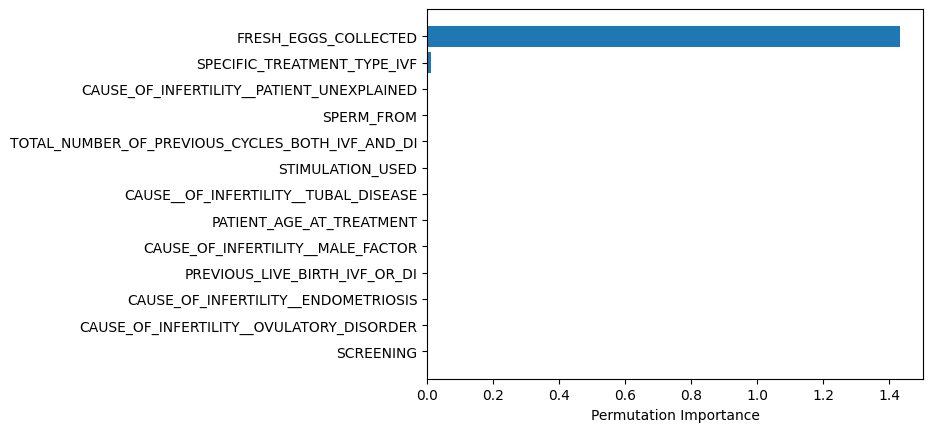

In [50]:
svr =  SVR(kernel='rbf', C=1.0, epsilon=1)
svr.fit(X_train_embryos, y_train_embryos)

perm_importance = permutation_importance(svr, X_train_embryos, y_train_embryos)

feature_names = X_train_embryos.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [51]:
perm_importance.importances_mean

array([2.52594681e-04, 4.55087596e-04, 2.85728031e-04, 6.16589119e-05,
       2.36406203e-04, 8.67544948e-04, 1.24033995e-04, 2.94067631e-04,
       5.13878867e-04, 1.43205843e+00, 6.01389337e-05, 1.26368666e-02,
       2.09476288e-04])

In [52]:
1.43205843/perm_importance.importances_mean.sum()

0.9889524423425017

In [33]:
# SVR WITH FRESH EGGS COLLECTED STANDARDISED
model = SVR
metrics_list = ['mae', 'mse', 'rmse']
params = {}
results_SVR = regressor_model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
                                       k=10, standardize=True, columns_to_standardize=['FRESH_EGGS_COLLECTED'])


CV RESULTS


,mae,mse,rmse
Mean,1.562286,5.344212,2.311288
Standard Deviation,0.023287,0.217986,0.046461



TEST RESULTS


,mae,mse,rmse
Value,3.037385,16.002738,4.000342


In [16]:
# SVR WITHOUT FRESH EGGS COLLECTED
model = SVR
metrics_list = ['mae', 'mse', 'rmse']
params = {}
results_SVR_WITHOUT = regressor_model_pipeline(X_train_embryos.drop(columns=['FRESH_EGGS_COLLECTED'], axis=1), 
                                        y_train_embryos, X_test_embryos.drop(columns=['FRESH_EGGS_COLLECTED'], axis=1), 
                                        y_test_embryos, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,2.978237,16.198511,4.023803
Standard Deviation,0.050152,0.700380,0.086709



TEST RESULTS


,mae,mse,rmse
Value,2.97845,16.144779,4.018057


### Multilayer Perceptron Regressor (MLPR)

In [140]:
model = MLPRegressor
metrics_list = ['mae', 'mse', 'rmse']
params = {'random_state': 42, 'max_iter':1000}
results_MLPR = regressor_model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10)


CV RESULTS


,mae,mse,rmse
Mean,1.573807,5.269530,2.295151
Standard Deviation,0.026340,0.197571,0.042568



TEST RESULTS


,mae,mse,rmse
Value,3.023693,15.955709,3.99446


## **STAGE 3 MODELS**

In [20]:
X_test_live_birth = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_test_live_birth['FRESH_EGGS_COLLECTED'] = results_BEST1['y_test_pred'].astype(int)
X_test_live_birth['TOTAL_EMBRYOS_CREATED'] = results_BEST2['y_test_pred'].astype(int)
X_test_live_birth = X_test_live_birth.reindex(columns=X_train_live_birth.columns)

In [21]:
def log_likelihood(y_true, y_pred):
    """Calculate the log-likelihood loss between true labels and predicted labels.
    
    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_pred (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).
    
    Returns:
        float: Negative log-likelihood loss value.
    """

    # To prevent log(0)
    epsilon = 1e-7 
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute the log likelihood
    log_likelihood = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    return -np.sum(log_likelihood)

In [22]:
def find_optimal_threshold(y_true, y_proba):
    """Find the optimal threshold for binary classification based on ROC curve.

    This function computes the Receiver Operating Characteristic (ROC) curve
    and then finds the threshold where the difference between True Positive Rate (TPR)
    and False Positive Rate (FPR) is maximized.

    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_proba (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).

    Returns:
        float: The optimal threshold for binary classification.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [23]:
def apply_smote(X_train, y_train):
    """Apply Synthetic Minority Over-sampling Technique (SMOTE) to training data.
    
    This function balances the class distribution in the training set by generating
    synthetic samples for the minority class using SMOTE.

    Args:
        X_train (numpy.ndarray or pandas.DataFrame): Training features. Shape should be (n_samples, n_features).
        y_train (numpy.ndarray or pandas.Series): Training labels. Shape should be (n_samples,).

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Resampled training features and labels.
        
        - X_train_res (numpy.ndarray): Resampled training features. Shape will be (n_resampled_samples, n_features).
        - y_train_res (numpy.ndarray): Resampled training labels. Shape will be (n_resampled_samples,).
    """
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

In [24]:
def create_poly_features(df, include_list=['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI'], degree=2):
    """
    Generates polynomial features with coherent names.

    Args:
        df (DataFrame): A pandas DataFrame containing the features.
        include_list (list): List of original features for which squared terms should be included.
        degree (int): The degree of the polynomial features. Default is 2.
    
    Returns:
        DataFrame: A new DataFrame with the polynomial features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df)

    # Generate coherent names
    poly_feature_names = []
    
    for d in range(1, degree+1):
        comb = combinations_with_replacement(df.columns, d)
        for i in list(comb):
            if len(set(i)) == 1:  # all elements in the combination are the same
                if d == 1: # no need to show power for d=1
                    poly_feature_names.append(i[0])
                else:
                    poly_feature_names.append(i[0] + "^" + str(d))
            else:
                poly_feature_names.append(" ".join(i))

    # Create a new DataFrame
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    if include_list is not None:
        # List of columns to drop
        drop_columns = [col for col in poly_df.columns if "^" in col and col.split("^")[0] not in include_list]
        poly_df.drop(columns=drop_columns, inplace=True)
    
    return poly_df

In [25]:
def model_pipeline(X_train, y_train, X_test, y_test, model, metrics_list, params={},
k=10, stratified=False, AIC=False, smote=False, SHAP=False,
optimal_threshold=True, importances=False):

    """Runs a machine learning model pipeline with various options.

    This function constructs a machine learning pipeline with optional techniques such as SMOTE
    and stratified k-fold cross-validation. It trains the model, evaluates it with specified metrics,
    and can optionally calculate AIC/BIC - to be used when dealing with parametric models, feature 
    importances, SHAP values, and optimal thresholds.

    Args:
        X_train (pandas.DataFrame): Training data.
        y_train (pandas.Series): Training labels.
        X_test (pandas.DataFrame): Test data.
        y_test (pandas.Series): Test labels.
        model (object): Uninitialized machine learning model.
        metrics_list (list of str): List of metrics to evaluate. Must be keys in the 'metrics' dictionary.
        params (dict, optional): Parameters to pass to the model. Default is an empty dictionary.
        k (int, optional): Number of folds in KFold cross-validation. Default is 10.
        stratified (bool, optional): Whether to use StratifiedKFold. Default is True.
        AIC (bool, optional): Whether to compute Akaike Information Criterion. Default is False.
        smote (bool, optional): Whether to use SMOTE for oversampling. Default is False.
        SHAP (bool, optional): Whether to compute SHAP values. Default is False.
        optimal_threshold (bool, optional): Whether to find optimal threshold for classification. Default is True.
        importances (bool, optional): Whether to compute feature importances. Default is False.

    Returns:
        dict: Dictionary containing various evaluation results such as cross-validation scores,
            test scores, feature importances, and more. The specific keys depend on the input arguments.
    """
    
    # Map metric names to functions
    metrics = {
        'accuracy': balanced_accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'auc': roc_auc_score,
        }

    # Create a pipeline with the specified model and parameters
    steps = []
    # Check if polynomial features are requested and add to the pipeline if necessary

    if smote:
        steps.append(('smote', SMOTE()))
        
    steps.append(('model', model(**params)))
    #pipeline = Pipeline(steps)
    pipeline = ImbPipeline(steps)

    # Initialize KFold cross-validation or Stratified KFold if stratified=True
    if stratified:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Compute the specified metrics using cross-validation
    cv_results = {}
    thresholds = []
    for metric in metrics_list:
        scorer = make_scorer(metrics[metric])
        cv_scores = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)

            if optimal_threshold and metric != 'auc':
                y_train_proba_fold = pipeline.predict_proba(X_train_fold)[:, 1]
                threshold = find_optimal_threshold(y_train_fold, y_train_proba_fold)
                thresholds.append(threshold)
            else:
                threshold = 0.5
                
            y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

            if metric == 'auc':
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred_proba))
            else:
                y_val_pred = (y_val_pred_proba >= threshold).astype(int)
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred))

        # Calculate confidence intervals
        cv_results[metric] = (np.mean(cv_scores), np.std(cv_scores))

    cv_results = pd.DataFrame(cv_results, columns=metrics_list).T
    cv_results.columns = ['Mean', 'Standard Deviation',]
    cv_results = cv_results.T

    # Compute the average optimal threshold from cross-validation
    avg_threshold = np.mean(thresholds) if thresholds else 0.5
    print('Average optimal threshold = ' + str(round(avg_threshold, 3)))

    # Fit the model on the full training set
    pipeline.fit(X_train, y_train)

    # Feature importances
    if importances:
        feature_importances = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            fitted_model = pipeline.named_steps['model']

            if hasattr(fitted_model, 'feature_importances_'):
                fold_importance = fitted_model.feature_importances_
            elif hasattr(fitted_model, 'coef_'):
                fold_importance = np.abs(fitted_model.coef_[0])
            else:
                perm_importance = permutation_importance(fitted_model, X_test_fold, y_test_fold)
                fold_importance = perm_importance.importances_mean

            feature_importances.append(fold_importance)

        # Compute mean and standard deviation of feature importances
        feature_importances_mean = np.mean(feature_importances, axis=0)
        feature_importances_std = np.std(feature_importances, axis=0)
        
        importances_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance_mean': feature_importances_mean,
            'importance_std': feature_importances_std
            })
        
        # Sort by importance_mean in descending order
        importances_df = importances_df.sort_values(by='importance_mean', ascending=False)
    
    else:
        importances_df = pd.DataFrame()

    # Compute the specified metrics on the test set
    test_results = {}
    for metric in metrics_list:
        scorer = metrics[metric]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
        if metric == 'auc':
            test_score = scorer(y_test, y_test_proba)
        else:
            y_test_pred = (y_test_proba >= avg_threshold).astype(int)
            test_score = scorer(y_test, y_test_pred)
        test_results[metric] = test_score

    test_results = pd.DataFrame(test_results, index=['Value'], columns=metrics_list).T
    test_results = test_results.T

    # Compute the confusion matrix on the test set
    conf_matrix = confusion_matrix(y_test, y_test_pred) 

    # Output mean and std of cross-validation scores and test set scores
    output = {
        'cv_results': cv_results,
        'test_results': test_results,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba, 
    }

    if AIC:
        y_pred_train_prob = pipeline.predict_proba(X_train)[:, 1] # Get predicted probabilities for the positive class
        n = X_train.shape[0] # Number of observations
        k = len(pipeline.named_steps['model'].coef_[0]) + 1 # Number of parameters in the model, adding 1 for intercept
        logL = log_likelihood(y_train, y_pred_train_prob)
        aic = 2 * k - 2 * logL
        bic = np.log(n) * k - 2 * logL
        output['aic'] = aic
        print('AIC: '+str(round(aic, 3)))
        output['bic'] = bic
        print('BIC: '+str(round(bic, 3)))

    output['feature_importances'] = importances_df

    # Print CV results
    print('')
    print('CV RESULTS')
    display(cv_results)
    print('')

    #Print Test results
    print('TEST RESULTS')
    display(test_results)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
    disp.plot(cmap="Oranges",  colorbar=False)
    plt.title('Test Set Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('confusion_matrix_final.png', bbox_inches='tight', dpi=600)
    plt.show()
    print('')

    #Print Features analysis
    if importances:
        print('FEATURES ANALYSIS')
        display(importances_df.head(20))

    if SHAP:
        # Compute SHAP values
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            explainer = shap.TreeExplainer(pipeline.named_steps['model'])
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

        elif hasattr(pipeline.named_steps['model'], 'coef_'):
            explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_train)
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

    return output

In [26]:
def compute_grid_search(model, param_grid, X_train, y_train):
    """
    Perform a grid search on a model using Stratified K-Fold cross-validation.

    Args:
        model (estimator object): Estimator or model to be used.
        param_grid (dict): Dictionary of parameters for grid search.
        X_train (array-like or pd.DataFrame): Training data features.
        y_train (array-like or pd.Series): Training data labels.
    
    Returns:
        GridSearchCV: Fitted GridSearchCV object.
    """

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=skf, 
        scoring='roc_auc', 
        verbose=1,  
        n_jobs=-1   
    )
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    
    return grid_search


### Simple Logistic Regression

Average optimal threshold = 0.461
AIC: -42507.102
BIC: -42380.77

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.657611,0.388924,0.750914,0.512295,0.703164
Standard Deviation,0.004793,0.004882,0.021036,0.004977,0.007127



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.60104,0.338927,0.722296,0.461365,0.634273


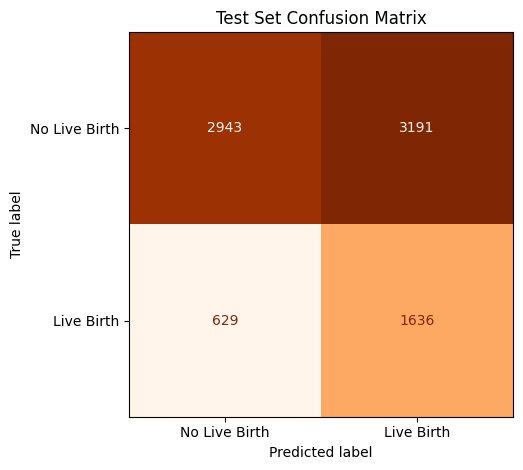

In [39]:
# Simple Logistic Regression
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

### Squared Logistic Regression

Average optimal threshold = 0.44
AIC: -41050.659
BIC: -40040.003

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.661367,0.381104,0.806556,0.517531,0.711659
Standard Deviation,0.005426,0.006610,0.011415,0.004782,0.006741



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.597178,0.322719,0.863576,0.469853,0.636241


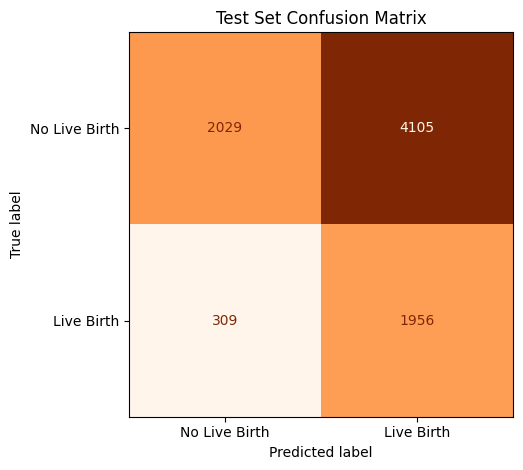

In [45]:
# Squared Logistic Regression
X_train_poly = create_poly_features(X_train_live_birth)
X_test_poly = create_poly_features(X_test_live_birth)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':6000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Average optimal threshold = 0.435
AIC: -41050.862
BIC: -40040.206

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.660743,0.379975,0.810865,0.515916,0.709067
Standard Deviation,0.004263,0.004658,0.015094,0.003348,0.006917



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.59514,0.321393,0.863576,0.468447,0.636032


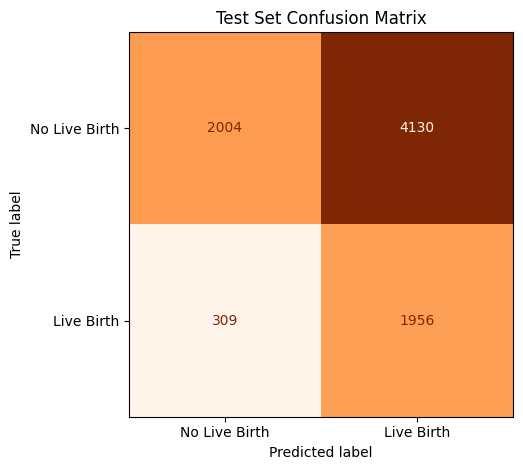

In [61]:
# Squared Logistic Regression with SMOTE - Does not improve performance
X_train_poly = create_poly_features(X_train_live_birth)
X_test_poly = create_poly_features(X_test_live_birth)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':6000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=True, SHAP=False, optimal_threshold=True)

In [26]:
model = LogisticRegression(solver='saga', max_iter=10000, random_state = 42, class_weight='balanced')

# Define the parameter grid for C
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Call the compute_grid_search function
grid_search_result = compute_grid_search(model, param_grid, X_train_poly, y_train_live_birth)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'C': 0.1, 'penalty': 'l1'}


Average optimal threshold = 0.459
AIC: -41453.016
BIC: -40442.36

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.661097,0.383929,0.791099,0.516808,0.710941
Standard Deviation,0.005594,0.006147,0.021557,0.005384,0.007208



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.609053,0.335273,0.814128,0.474952,0.63458


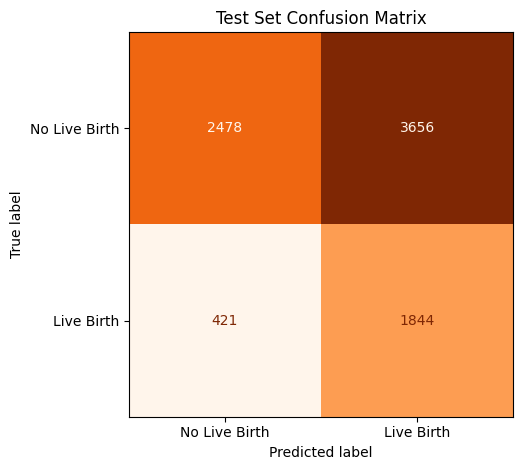

In [27]:
# Squared Logistic Regression
X_train_poly = create_poly_features(X_train_live_birth)
X_test_poly = create_poly_features(X_test_live_birth)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':6000, 'random_state': 42, 'class_weight': 'balanced', 'penalty':'l1', 'solver':'saga', 'C':0.1, 'n_jobs':-1}
results_LR2 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=False)

Average optimal threshold = 0.455
AIC: -41479.901
BIC: -40553.467

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.660870,0.382383,0.797167,0.516693,0.710884
Standard Deviation,0.005255,0.004142,0.025084,0.005324,0.007288



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.608071,0.334236,0.817219,0.474433,0.634686


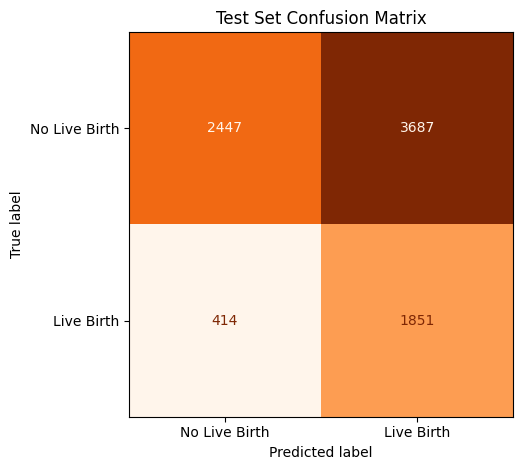


FEATURES ANALYSIS


,feature,importance_mean,importance_std
88,STIMULATION_USED TOTAL_EMBRYOS_CREATED,0.148154,0.003189
10,TOTAL_EMBRYOS_CREATED,0.117707,0.004488
0,PATIENT_AGE_AT_TREATMENT,0.113284,0.002453
7,STIMULATION_USED,0.103790,0.003805
12,SPECIFIC_TREATMENT_TYPE_IVF,0.100346,0.005296
90,STIMULATION_USED SPECIFIC_TREATMENT_TYPE_IVF,0.094895,0.004692
26,PATIENT_AGE_AT_TREATMENT SPECIFIC_TREATMENT_TY...,0.066196,0.005616
21,PATIENT_AGE_AT_TREATMENT STIMULATION_USED,0.058560,0.003659
14,PATIENT_AGE_AT_TREATMENT^2,0.058237,0.001219
1,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.049867,0.005528


In [27]:
# Squared Logistic Regression
X_train_poly = create_poly_features(X_train_live_birth, include_list=['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI', 'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED'])
X_test_poly = create_poly_features(X_test_live_birth, include_list=['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI', 'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED'])
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':6000, 'random_state': 42, 'class_weight': 'balanced', 'penalty':'l1', 'solver':'saga', 'C':0.1, 'n_jobs':-1}
results_LR2 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)

In [28]:
results_LR2['feature_importances'].to_csv('cascade2_importances.csv', index=True)

In [21]:
with open('probas_cascade2.txt', 'w') as f:
    for item in results_LR2['y_test_proba']:
        f.write("%s\n" % item)

### Random Forest

Average optimal threshold = 0.42

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.593037,0.366311,0.515075,0.428013,0.654411
Standard Deviation,0.008322,0.008614,0.018872,0.010400,0.007514



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.563815,0.314159,0.658278,0.425332,0.574542


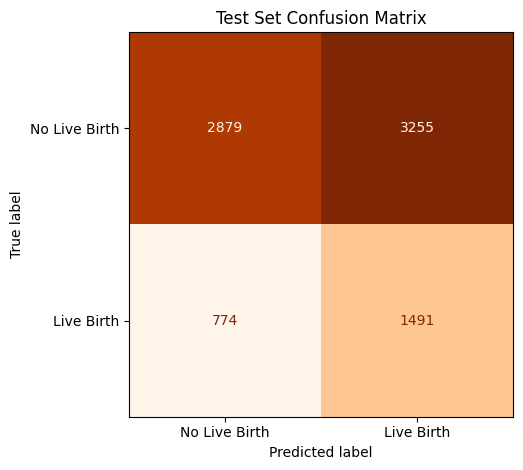


FEATURES ANALYSIS


,feature,importance_mean,importance_std
9,FRESH_EGGS_COLLECTED,0.339521,0.003108
10,TOTAL_EMBRYOS_CREATED,0.301700,0.001506
0,PATIENT_AGE_AT_TREATMENT,0.106471,0.001173
1,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.099144,0.002454
12,SPECIFIC_TREATMENT_TYPE_IVF,0.026250,0.000884
4,CAUSE_OF_INFERTILITY__MALE_FACTOR,0.023421,0.000830
5,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.019993,0.000522
2,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,0.017625,0.000607
3,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,0.015388,0.000794
13,PREVIOUS_LIVE_BIRTH_IVF_OR_DI,0.014737,0.000493


In [23]:
# Random Forest
model = RandomForestClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'class_weight': 'balanced', 'n_estimators': 100}
results_RF = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, importances=True)

### XGBoost

Average optimal threshold = 0.52

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.653212,0.392445,0.716684,0.506817,0.703116
Standard Deviation,0.003399,0.008035,0.026250,0.003310,0.007692



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.609176,0.336999,0.798234,0.473919,0.62604


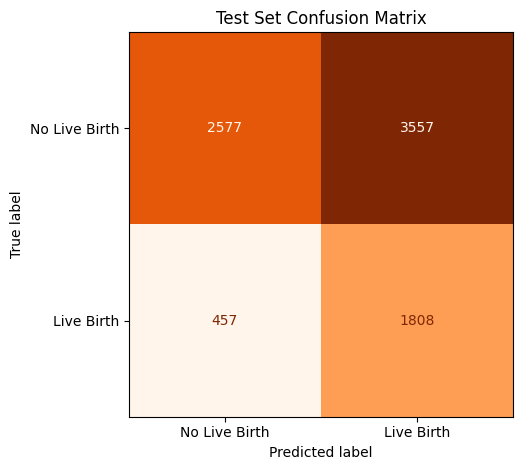

In [42]:
# XGBoost
counter = Counter(y_train_live_birth)
estimate = counter[0] / counter[1]
model = XGBClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'scale_pos_weight': estimate}
results_XGB = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

### Multilayer Perceptron

Average optimal threshold = 0.265

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.660186,0.384691,0.783818,0.515755,0.711033
Standard Deviation,0.005417,0.007777,0.029022,0.005190,0.006506



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.603765,0.33224,0.804857,0.47033,0.627654


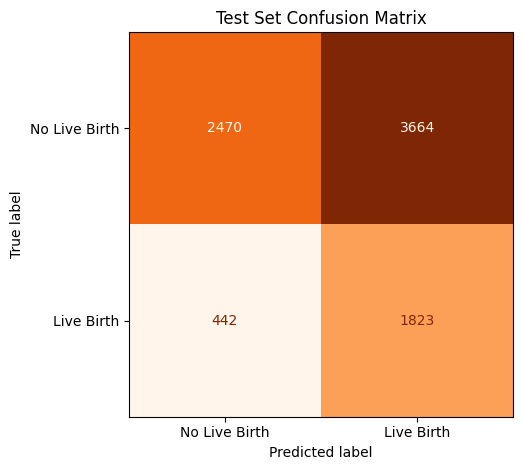

In [43]:
# Multilayer Perceptron
model = MLPClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 1000}
results_MLP = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)